# Graph Neural Nets for Credit Scoring

**Note**: This is a stripped down version of the SageMaker JumpStart Solution titled "Graph-Based Credit Scoring" for academic/education purposes. Please use the production version for purposes other than review, as this version is not as performant and does not use all SageMaker resources as the solution publicly released in JumpStart. For a brief overview, please see the related [blog](https://aws.amazon.com/blogs/machine-learning/build-a-corporate-credit-ratings-classifier-using-graph-machine-learning-in-amazon-sagemaker-jumpstart/). 

Credit scoring using just tabular data may be improved by exploiting data on business linkages, for which you may construct a graph, denoted as `CorpNet` -- for corporate network. You can then apply graph machine learning classification using GNNs on this graph and a tabular feature set for the nodes, to build a better ML model by further exploiting the information in network relationships. 

Graph Neural Nets (GNNs) are emerging as an interesting way to enhance existing machine learning models in several domains, see: https://www.amazon.science/blog/amazon-at-wsdm-the-future-of-graph-neural-networks

- Kernel: `PyTorch 1.10 Python 3.8 GPU Optimized` 
- Use GPU machine: `ml.g4dn.xlarge` (4 core CPU, 1 GPU, 16 GB RAM)

## Abstract 

Credit ratings are traditionally generated using models that use financial statement data and market data, which is typically in tabular form, i.e., numeric and categorical data. This model constructs a network of firms using text from SEC filings and shows that using the network of firm relationships with tabular data can generate more accurate rating predictions. The model demonstrates a methodology to use big data to extend tabular data credit scoring models, which have been used by the ratings industry for decades, to the class of machine learning models on networks.

## What does this notebook do? 

This notebook (and related auxilliary program and data files) demonstrate the following: 

- *Network data*: The solution shows how to construct a network of connected companies using the MD&A section from SEC 10-K/Q filings. We assume that companies with similar forward looking statements are likely to be connected for credit events, though this is but one approach to constructing a corporate graph. These connections are represented in a graph. The solution provides a single function that generates the network. 

- *Tabular data*: For graph node features, the solution uses the variables in the Altman Z-score model and the industry category of each firm. These are provided in a synthetic dataset made available for demonstration purposes.

- The graph data and tabular data are used to fit a rating classifier using graph neural nets (GNNs). 


## Part 1: Constructing a Corporate Network using SEC Filings (`CorpNet`)

- A simple approach is used to construct a network of credit connected companies using the text in the Management Discussion & Analysis (MD&A) section of the 10-K/Q filings, which are annual/quarterly reports companies are required to file with the SEC. The MD&A section usually contains the forward looking outlook for a company and also discusses trends and market conditions that may impact a firm. 

- To obtain the filings for each company that populates the `CorpNet`, use the AWS SageMaker JumpStart card titled "Financial TabText Data Construction". A blog showing how to do this is also available: https://aws.amazon.com/blogs/machine-learning/create-a-dashboard-with-sec-text-for-financial-nlp-in-amazon-sagemaker-jumpstart/. This data has already been collected and provided in the file `text_data.csv`.

- The graph is based on the distribution of cosine similarities between document embeddings of the MD\&A section of firms' 10-K/Q filings. The similarity of two firms is given by the following equation: $s = \frac{A \cdot B}{\|A\| \cdot \|B\|}$, where $A, B$ are document embeddings. Since these embedding vectors may contain negative values, it is possible to return negative values. However, links in the network are based on values where $s>0.5$. The distribution of pairwise cosine similarities is shown below and the cutoff used is deep in the right tail. However, this is without loss of generality, and other cutoffs may be used to modulate the number of links in the network. 

![cosine_sims_synthdata](https://sagemaker-solutions-prod-us-east-2.s3.us-east-2.amazonaws.com/sagemaker-graph-neural-net-models-for-financial-classification/1.1.0/docs/cosine_sims_synthdata.png)


- The degree distribution, i.e., the number of connections of each node in the graph, turns out to be power-law distributed, which is classic in small-world [scale-free](https://en.wikipedia.org/wiki/Scale-free_network) graphs, hence `CorpNet` appears to fall into this category of graphs. 

![degree_dist](https://sagemaker-solutions-prod-us-east-2.s3.us-east-2.amazonaws.com/sagemaker-graph-neural-net-models-for-financial-classification/1.1.0/docs/degree_dist.png)



## Part 2: The synthetic dataset of credit scoring features

The model used is a well-known bankruptcy prediction approach, from the seminal paper by Altman (1968). A brief summary is provided here. See also the description at this [site](https://www.creditguru.com/index.php/bankruptcy-and-insolvency/altman-z-score-insolvency-predictor). Similar information is also available on many other sites.

The model uses 8 inputs converted into 5 financial ratios: (i) Current assets ($CA$); (ii) Current liabilities ($CL$); (iii) Total Liabilities ($TL$); (iv) earnings before interest and taxes ($EBIT$); (v) Total Assets ($TA$); (vi) Net Sales ($NS$); (vii) Retained earnings ($RE$); and (viii) Market value of equity ($MVE$). The relationships between these 8 items are modeled as stipulated in the Altman model through the following five ratios: 
- A: EBIT / Total Assets 
- B: Net Sales / Total Assets
- C: Mkt Value of equity / Total Liabilities
- D: Working Capital / Total Assets
- E: Retained Earnings / Total Assets
 
The Z-score is then provided by the following formula, estimated using Linear Discriminant Analysis (LDA) and the coefficients in the formula are published widely by Altman.

$$
Zscore = 3.3 A + 0.99 B + 0.6 C + 1.2 D + 1.4 E
$$

High quality companies have high Z-scores and low quality companies have low ones. The simulated Z-scores used to construct our synthetic dataset are calibrated to broad balance-sheet, income-statement, and market data using averages for the U.S. economy from the following sources: 

- [Balance sheet data](https://fred.stlouisfed.org/release/tables?rid=434&eid=196197)
- [Income statement data](https://fred.stlouisfed.org/release/tables?rid=434&eid=195208)
- [Price to book](http://pages.stern.nyu.edu/~adamodar/New\_Home\_Page/datafile/pbvdata.html)

The numbers taken from these sources are used to extract total values for US companies for the 8 inputs mentioned above. In addition, we obtain the average price-to-book ($P2B$) ratio for US companies, book equity value ($EQ$) and then generate market value of equity ($MVE$) as $P2B(EQ+RE)$. Working capital ($WC$) is as usual, $CA-CL$, the difference between current assets and current liabilities. We normalized all simulated financial data by Total Assets. This normalization does not impact the Altman ratios in any way. 

This dataset of simulated companies and their financials is then enhanced with a column of ratings, where the ratings are mapped -- with some noise -- to the Z-score, such that higher Z-score firms are assigned higher quality ratings and lower Z-score firms get lower quality ratings. The dataset titled `tabular_data.csv` is also provided with this notebook. 

Given that the `CorpNet` graph is generated from real SEC filings, we compute "quality" scores for each MD&A section using JumpStart APIs for NLP scoring, see the JumpStart card titled "NLP Score Dashboard for SEC Text" and the related documentation [link](https://sagemaker-jumpstart-industry-pack.readthedocs.io/en/latest/smjsindustry.nlp_scorer.html). The quality scores are a net sum of positive NLP scores (positivity, polarity, safe, sentiment, certainty) and negative NLP scores (fraud, litigious, negative, uncertainty, risk). These quality scores are used to associate higher "quality" nodes with higher ratings firms in the synthetic tabular dataset. This injects a connection between `CorpNet` and the synthetic data.

We used the (MD&A) section of companies' SEC 10-K/Q filings to construct a corporate graph, `CorpNet`, already discussed above. The approach is based on the idea that companies facing similar risks will evidence similarities in their forward-looking statements in the MD&A section. Therefore, we construct a graph where each node is a company in the dataset and two companies are linked if the cosine similarity of their MD&A document embeddings is greater than 0.5. The notebook that accompanies this solution contains this generated graph data in addition to the tabular data described above. 

Therefore, we generate both, a graph using real SEC filings and associate it with the synthetic tabular data generated to match broad financial averages for US firms. 

**References**

- Altman, Edward I. “Financial Ratios, Discriminant Analysis and the Prediction of Corporate Bankruptcy.” The Journal of Finance 23, no. 4 (1968): 589–609. https://doi.org/10.1111/j.1540-6261.1968.tb00843.x.

- Altman, Edward I. “A Fifty-Year Retrospective on Credit Risk Models, the Altman Z -Score Family of Models and Their Applications to Financial Markets and Managerial Strategies.” Journal of Credit Risk 14, no. 4 (December 11, 2018): 1–34.


## Data Summary

1. The dataset has tabular data such as various accounting ratios (numerical) and industry codes (categorical). The dataset has $N = 3286$ rows. Rating labels are also added. These are the node features to be used with graph machine learning. 

2. The dataset also contains a corporate graph, which is undirected and unweighted. This solution also allows the user to tweak the structure of the graph by varying the way in which links are included. 

3. Classification using GNNs can be multi-category for all ratings or binary, divided between investment grade (rating levels AAA, AA, A, BBB) and non-investment grade (rating levels BB, B, CCC, CC, C, D). D=defaulted.  

Next we move on to using the graph and tabular data to demonstrate how GNNs are applied to this problem. 

>**<span style="color:RED">Important</span>**: 
>This solution is for demonstrative purposes only. It is not financial advice and should not be relied on as financial or investment advice. The associated notebooks, including the trained model, use synthetic data, and are not intended for production use. While text from SEC filings is used, the financial data is synthetically and randomly generated and have no relation to any company's true financials. Hence, the synthetically generated ratings also do not have any relation to a company's true rating. You are free to adapt this solution for your own use cases. 

This solution relies on a config file to run the provisioned AWS resources. Run the cell below to generate that file.

## Part 3: Load up the required packages and data

The solution uses several open source packages below and you should ensure that you comply with the terms of use of these packages. 

In [2]:
%%capture 
!pip install -I gensim bokeh networkx sagemaker

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from utils import construct_network_data

## Tabular Feature Set

We read in a file that contains all the data. It has the 5 Altman financial ratios A, B, C, D, E described in Part 2 above, and the binary rating class, as well as one-hot encoding for the industry categories. 

In [4]:
target_column = 'binary_rating'

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

rating_df = pd.read_csv('datasets/tabular_data.csv')

rating_df[target_column] = rating_df['Rating'].apply(lambda x: 1 if x in ['AAA', 'AA', 'A', 'BBB'] else 0)
rating_df['Rating'] = le.fit_transform(rating_df['Rating'])

rating_df.reset_index(inplace=True, drop=True)
rating_df.head()

,industry_code,CurrentLiabs,TotalLiabs,RetainedEarnings,CurrentAssets,NetSales,EBIT,MktValueEquity,Rating,binary_rating
0,D,20.868258,50.501544,32.547303,24.871286,14.774910,1.334931,238.571513,2,1
1,D,19.622967,50.352084,28.760326,29.103598,12.447340,1.137064,215.396468,2,1
2,D,21.474133,55.007104,29.903571,24.560932,13.074464,1.390076,232.182228,2,1
3,I,20.135293,50.225308,29.748943,26.070400,15.765115,1.203600,228.732074,2,1
4,D,17.417811,49.893589,29.480277,24.160795,12.612130,1.189818,236.955918,2,1


Finally, we prune the tabular feature set, by removing the label column `Rating`, which is for multiclass rating. This dataset still includes the label column `binary_rating` for binary classification, which is the use case we develop here. If multicategory classification is required, then we drop `binary_rating` instead and keep the `Rating` column. 

In [6]:
rating_df.drop(['Rating'], axis=1, inplace=True)

We now examine how much of the dataset has label 1 verus label 0. We see that the dataset is quite balanced.

In [7]:
np.mean(rating_df[target_column].values)

0.5410833840535606

## Implementing Graph Construction

In this section we use our custom approach to construct `CorpNet` using the text from SEC filings.   

Read the text data to construct network data.

In [8]:
text_df = pd.read_csv("datasets/text_data.csv", header=0)

### Construct the network
1. For each source node, i.e., a row in the dataset, find its neighbor nodes sorted from nearest to furthest based on some distance measurement. The distance measurement in this example is computed based on the embeddings of a text column **MDNA** generated from the **Doc2Vec** method. However, you may use embeddings from any algorithm, such as BERT, or financial embeddings from a pre-trained [RoBERTa-SEC model](https://aws.amazon.com/blogs/machine-learning/use-pre-trained-financial-language-models-for-transfer-learning-in-amazon-sagemaker-jumpstart/). 

2. For each source node, add a link if the document vector for a node has high cosine similarity with another node. Note that it is possible to generate zero links for some nodes. However, these nodes are still included in the graph. 

3. Add links, i.e., destination nodes for all nodes that are close in embedding space. 

4. The length of the `src` and `dst` lists will be the number of links in the network. They should both have the same length. 

5. The number of source nodes with links will differ from the number of destination nodes with links. Some nodes will be isolated, i.e., not linked at all. Both these numbers will be less than $N$. 

Finish generating the embedding matrix.
Number of nodes = 3286
Min of cosine similarities = -0.1438241599150775
Mean of cosine similarities = 0.2928721726340555
Median of cosine similarities = 0.28441738941193795
Number of nodes = 3286
Number of links (symmetric) = 179909.0
Average degree =  109.50030432136336
Check: number of links = 359818
CPU times: user 24min 56s, sys: 4.33 s, total: 25min
Wall time: 8min 46s


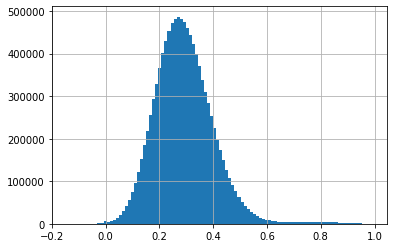

In [9]:
%%time
src_dst_dict = construct_network_data(text_df, text_column_name="MDNA", embedding_size=300, cutoff=0.5)

#### Drop isolated nodes and renumber all nodes

We will use the Deep Graph Library ([DGL](https://www.dgl.ai/)) for graph machine learning. DGL requires that all nodes are consecutively numbered, and the code below ensures no missing node numbers in a sequence of nodes, so all nodes are numbered consecutively. 

In [10]:
del_nodes = set(rating_df.index) - (set(src_dst_dict['src'] + src_dst_dict['dst']))

rating_df.drop(list(del_nodes), inplace=True)
rating_df['node'] = rating_df.index
rating_df.reset_index(inplace=True, drop=True)

In [11]:
node_map = {v:k for k,v in rating_df['node'].to_dict().items()}

src_dst_dict['src'] = [node_map[n] for n in src_dst_dict['src']]
src_dst_dict['dst'] = [node_map[n] for n in src_dst_dict['dst']]

In [12]:
# Check
print('Highest index =', max(rating_df.index))
print('# nodes =', len(rating_df))
print('# source nodes with links =', len(set(src_dst_dict['src'])))
print('# destination nodes with links =',len(set(src_dst_dict['dst'])))
print('# Linked nodes =', len(set(src_dst_dict['src'] + src_dst_dict['dst'])))
print('# isolated nodes =', len(rating_df) - len(set(src_dst_dict['src'] + src_dst_dict['dst'])))

Highest index = 3284
# nodes = 3285
# source nodes with links = 3285
# destination nodes with links = 3285
# Linked nodes = 3285
# isolated nodes = 0


This completes the preparation of the corporate graph, denoted as `CorpNet`. We save the source and destination nodes to store `CorpNet`. 

## Part 4: Train a baseline model without graph machine learning

It is useful to set a baseline that mimics a model that only uses the tabular data for each firm. This will enable a comparison of models that gain from enhancing the features used with graph data. In order to be agnostic to the baseline model and to set a competitive baseline, AutoGluon Tabular using a SageMaker AutoGluon Container is used to fit ML models the tabular data. AutoGluon has been shown to beat most other AutoML packages in kaggle competitions, discussed in this [blog](https://aws.amazon.com/blogs/opensource/machine-learning-with-autogluon-an-open-source-automl-library/). It uses stack-ensembling over a wide range of models and exploits the tabular feature set comprehensively. In contrast, for graph ML we use the [deep graph library (DGL)](https://www.dgl.ai/) that only fits one GNN which may be optimally chosen with hyperparmater optimization and will likely only beat AutoGluon in accuracy if there is sufficient information in the graph that adds value to the classifier. 

The next few blocks of code will train a rating classifier on the tabular features in this solution. 

Begin by uploading the train and test data to a S3 bucket.

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state=46, stratify=rating_df[target_column].values)

In [14]:
train_df.shape, test_df.shape

((2628, 10), (657, 10))

In [15]:
!mkdir -p ag_processed_data
ag_train_df = train_df.drop(["node"], axis=1)
ag_test_df = test_df.drop(["node"], axis=1)
ag_train_df.to_csv("ag_processed_data/train_data.csv", header=True, index=False)
ag_test_df.to_csv("ag_processed_data/test_data.csv", header=True, index=False)

In [16]:
! pip install autogluon.tabular==0.5.2

In [17]:
from autogluon.tabular import TabularDataset, TabularPredictor
import logging

We run model training in an AutoGluon-Tabular. Recall that the classification task is a binary one, to predict whether a company is investment grade or below investment grade.

The next block of code shows how simple the code is to run AutoGluon-Tabular in local mode.

In [18]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()


target_column = "binary_rating"
eval_metric = "f1"
output_path_ag = "ag-results"

train_data = TabularDataset("ag_processed_data/train_data.csv")

ag_predictor_args = {
    "label": target_column,
    "path": output_path_ag,
    "eval_metric": eval_metric,

}

predictor = TabularPredictor(**ag_predictor_args).fit(train_data)

logger.info("Best model: %s", predictor.get_model_best())

# Leaderboard
lb = predictor.leaderboard()
lb.to_csv(f'{output_path_ag}/leaderboard.csv', index=False)

Beginning AutoGluon training ...
AutoGluon will save models to "ag-results/"
AutoGluon Version:  0.5.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    2628
Train Data Columns: 8
Label Column: binary_rating
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    13860.79 MB
	Train Data (Original)  Memory Usage: 0.3 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the feature

[2022-09-21 20:51:04.523 pytorch-1-10-cpu-py-ml-g4dn-xlarge-30b5abea8f5791981f5aa8c76fc2:3107 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-21 20:51:04.697 pytorch-1-10-cpu-py-ml-g4dn-xlarge-30b5abea8f5791981f5aa8c76fc2:3107 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
	0.7674	 = Validation score   (f1)
	3.84s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge ...
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==0.5.2`.
Fitting model: WeightedEnsemble_L2 ...
	0.7768	 = Validation score   (f1)
	0.7s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 9.55s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("ag-results/")


                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.776801       0.086586  5.105436                0.001750           0.700120            2       True          8
1       NeuralNetTorch   0.767361       0.012641  3.836592                0.012641           3.836592            1       True          7
2       ExtraTreesGini   0.760070       0.072196  0.568724                0.072196           0.568724            1       True          5
3       ExtraTreesEntr   0.752197       0.071113  0.570130                0.071113           0.570130            1       True          6
4     RandomForestGini   0.740484       0.078830  0.675204                0.078830           0.675204            1       True          3
5     RandomForestEntr   0.740351       0.071828  0.764528                0.071828           0.764528            1       True          4
6       KNeighborsUnif   0.694545       0

### Perform inference on the model trained by AutoGluon Model

We assess the performance of the tabular model on the test data set. 


In [19]:
#model = TabularPredictor.load(model_dir)
globals()["column_names"] = predictor.feature_metadata_in.get_features()

ag_pred_prob = predictor.predict_proba(ag_test_df.drop([target_column], axis=1)).values
ag_pred_prob = np.array(ag_pred_prob)
ag_pred = np.where(ag_pred_prob[:,1] > 0.5, 1, 0)

### Compute evaluation metrics on the test data

In [20]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, matthews_corrcoef, balanced_accuracy_score

In [21]:
ag_y_true = ag_test_df[target_column].values
metrics_results = classification_report(ag_y_true, ag_pred, zero_division=1, output_dict=True)
ag_results = pd.DataFrame(
    {
        "F1 Score": metrics_results["1"]["f1-score"],
        "ROC AUC": roc_auc_score(ag_y_true, ag_pred_prob[:, 1]),
        "Accuracy": metrics_results["accuracy"],
        "MCC": matthews_corrcoef(ag_y_true, ag_pred),
        "Balanced Accuracy": balanced_accuracy_score(ag_y_true, ag_pred),
        "Precision": metrics_results["1"]["precision"],
        "Recall": metrics_results["1"]["recall"],        
    },
    index=["AutoGluon"]
)

In [22]:
ag_results

,F1 Score,ROC AUC,Accuracy,MCC,Balanced Accuracy,Precision,Recall
AutoGluon,0.732804,0.753056,0.692542,0.377198,0.684726,0.6925,0.77809


## Part 5: A Brief Introduction to Graph Machine Learning

We assume that you have some knowledge of graph theory. The summary below is a brief description of graph ML. 

1. Machine learning using graph data is a broad subject and good expositions are available in books by Hamilton (2020); Blumauer and Nagy (2020); Ma and Tang (2021). (References below.) 

2. Graph machine learning requires representing the information on graphs as graph embeddings, of which a particular type is node embeddings. We can use deep learning methods to construct quality node embeddings using algorithms like [node2vec](https://snap.stanford.edu/node2vec/). You may also construct embeddings for links in a graph and also embeddings for entire graphs. 

3. Neural networks are used for classification with graph convolutional network (GCN) layers that use the normalized graph adjacency matrix with activation functions (e.g., ReLU) to incorporate network relationships into deep graph learning (Kipf and Welling, 2017). 

4. A graph (or network) $G$ comprises nodes or vertexes (set $V$, of size $|V|=n$) and links or edges (set $E$, of size $|E|=m$) and hence may be written as $G(V,E)$. The edge set may be (i) directed or undirected, (ii) weighted or unweighted. The graph may have single node types and single edge types, in which case it is denoted as "homogeneous" graph, but if it has multiple types of nodes or links, then it is known as a "heterogeneous" graph. For example, in a lending network, some nodes may be borrowers, others lenders, and some both. The number of links each node has is known as the "degree" of the node, and the distribution of number of links across all nodes is called the "degree distribution" of the graph, shown earlier. Our solution here is based on nodes that are of one type, companies, and hence uses a homogeneous graph.  

5. The links in a homogeneous graph are often represented by an "adjacency matrix" $A$ of size $n \times n$, which represents all links in the graph with non-zero values, such that a link from node $i$ to node $j$ is designated by $A_{ij}>0$. For an undirected graph, matrix $A$ is symmetric, i.e., $A_{ij}=A_{ji}$. An alternate data structure for a graph is a links table $L$ of size $m \times 3$, with one row for each link from node $i$ to node $j$ with edge weight $w$, which we can denote as $L(i,j,w)$. The links table is a parsimonious data structure compared to the adjacency matrix, and for large (and sparse) graphs, is much more memory efficient.

6. Node representations (embeddings) are vectors in $d$-dimensional embedding space. Algorithms to generate these embeddings aim to map similarity of nodes in the graph to closeness in the embedding vector space. Let the $d$-dimensional embedding vectors for nodes $i,j$ be denoted as $z_i, z_j \in {\cal R}^d$. We try to find vectors that map into the values in the adjacency matrix $A$, i.e., minimize loss ${\cal L} = \sum_i \sum_j \parallel z_i^\top \cdot z_j - A_{ij} \parallel^2$.

7. GCNs are trained to produce node, link, and graph embeddings. Node embeddings are a function of the features set of the node and its nearest neighbors, which may be a single hop away to many hops away (Cao, Lu, Xu (2015); Wu et al (2019)), a modeling choice, and have fixed length, dimension $d$. See Perozzi et al. (2014) for an efficient approach, known as `DeepWalk`, improved upon with biased random walks in the node2vec algorithm of Grover and Leskovec (2016). 

8. These *shallow* embeddings discussed above ignore data available on node features. They also cannot generate embeddings for new nodes that were not part of the original training of node embeddings. Better {\it deep} encodings for nodes is possible with deep learning, using graph neural nets (GNNs). For a detailed exposition, see Scarselli et al (2009), a brief overview is as follows. Assume $k$ features at each of the $n$ nodes, resulting in a feature table $X \in {\cal R}^{k \times n}$, with vector $x_i$ being the feature vector for node $i$. In our setting, these are all the variables that define the credit risk of a firm. The approach to generate embeddings is as follows. Assume a fixed neighborhood of a node (say 3 hops) and look at the 3-level tree below the chosen node. Suppose the node $i$ is connected to 4 nodes, each of which is connected to $1,2,4,3$ nodes respectively, and each of these nodes is also connected to more nodes (the exact number of connections is not important and the numbers here are merely illustrative, these links may contain cycles and thus include recursion). Assuming we have a representation for each of the 4 nodes connected to node $i$ already, then we can average these vectors, feed them into a neural network ${\cal N}$ where the network generates a final output of embedding size $d$ as a node embedding for node $i$. Note that this approach from one hop away, can be recursively extended to the next 2 hops as well, ending with (in this case) 3 hops away (the leaves of the tree are the 3-hop nodes). At the last level, the inputs are the $k$-dimensional feature vectors for each node. These get transformed by weighting matrices in the vectors as we go up the tree to end up with the final embedding for node $i$. The node-level generated embeddings can be used with loss functions for similarity as discussed before in unsupervised mode, or on a node classification task in supervised mode. Once the neural net has been trained, you may generate embeddings for new nodes as they are added to the graph. This was not possible with the simpler embeddings discussed in the preceding paragraph.  

9. So far, input vectors from the lower levels of a subtree emanating from a target node have been aggregated by weighted averaging of the inputs of neighbor nodes along with the embedding of the target node. Here, we use DGL, which implements a node embedding scheme known as [GraphSAGE](http://snap.stanford.edu/graphsage/). This approach extends neighborhood aggregation to concatenating the target node embedding with a function of the neighborhood node embeddings that may be simply a mean (pooling), or other forms of pooling, as well as applying more complex activations such as LSTMs using graph convolutional networks (GCNs). We will use these GCNs below. 

10. The embeddings and node features are now used to learn a classification neural net. 

### References

- Cao, Shaosheng, Wei Lu, and Qiongkai Xu. “GraRep: Learning Graph Representations with Global Structural Information.” In Proceedings of the 24th ACM International on Conference on Information and Knowledge Management, 891–900. CIKM ’15. New York, NY, USA: Association for Computing Machinery, 2015. https://doi.org/10.1145/2806416.2806512.
- Grover, Aditya, and Jure Leskovec. “Node2vec: Scalable Feature Learning for Networks.” In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 855–64. KDD ’16. New York, NY, USA: Association for Computing Machinery, 2016. https://doi.org/10.1145/2939672.2939754.
- Hamilton, William L. Graph Representation Learning. San Rafael, California: Morgan & Claypool, 2020.
- Blumauer, Andreas, and Helmut Nagy. The Knowledge Graph Cookbook. edition mono/monochrom, 2020.
- Ma, Yao, and Jiliang Tang. Deep Learning on Graphs. Cambridge: Cambridge University Press, 2021.
- Kipf, Thomas N., and Max Welling. “Semi-Supervised Classification with Graph Convolutional Networks.” In 5th International Conference on Learning Representations, ICLR 2017, Toulon, France, April 24-26, 2017, Conference Track Proceedings. OpenReview.net, 2017. https://openreview.net/forum?id=SJU4ayYgl.
- Perozzi, Bryan, Rami Al-Rfou, and Steven Skiena. “DeepWalk: Online Learning of Social Representations.” In Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 701–10. KDD ’14. New York, NY, USA: Association for Computing Machinery, 2014. https://doi.org/10.1145/2623330.2623732.
- Scarselli, F., M. Gori, A. C. Tsoi, M. Hagenbuchner, and G. Monfardini (2009, January). "The graph neural
network model." IEEE transactions on neural networks 20 (1), 61–80. https://dl.acm.org/doi/10.1109/TNN.2008.2005605
- Wu, Felix, Tianyi Zhang, Amauri Holanda de Souza Jr., Christopher Fifty, Tao Yu, and Kilian Q. Weinberger. “Simplifying Graph Convolutional Networks.” ArXiv:1902.07153 [Cs, Stat], June 20, 2019. http://arxiv.org/abs/1902.07153.

## Part 6: Train a Graph Convolutional Network with DGL using SageMaker Pytorch Container

We use an adaptation of the GraphSAGE model (http://snap.stanford.edu/graphsage/) in conjunction with the Deep Graph Library (DGL, https://www.dgl.ai/). The steps are as follows:

1. Read in graph data from S3 and create the source and destination node lists for `CorpNet`. 
2. Read in the graph node feature sets (train and test).
3. Set tunable hyperparameters. 
4. Call the specialized graph machine learning container running PyTorch to fit the GNN without hyperparameter optimization (HPO).
5. Redo graph ML with HPO.

Save the model to the local directory and upload them to your S3 bucket to be ready for predictive use.

In [23]:
# Read in graph data
src_dst_df = pd.DataFrame.from_dict(src_dst_dict)

In [24]:
src_dst_df.shape

(359818, 2)

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
col_to_normalization = ["CurrentLiabs", "TotalLiabs", "RetainedEarnings", "CurrentAssets", "NetSales", "MktValueEquity"]
col_to_onehot_encoded = ["industry_code"]

First, we normalize the numerical columns for both train and test dataset.

In [26]:
scaler = StandardScaler()
train2normalize = train_df[col_to_normalization].values
scaler.fit(train2normalize)
normalized_train = scaler.transform(train2normalize)
train_df[col_to_normalization] = normalized_train

In [27]:
normalized_test = scaler.transform(test_df[col_to_normalization].values)
test_df[col_to_normalization] = normalized_test

Next, one-hot encode the categorical column for both train and test dataset.

In [28]:
enc = OneHotEncoder(handle_unknown='error')
train2enc = train_df[col_to_onehot_encoded].values
enc.fit(train2enc)
encoded_train = enc.transform(train2enc).toarray()

enc_col_names = []
for each in zip(col_to_onehot_encoded, enc.categories_):
    enc_col_names += [each[0]+f"_{x}" for x in each[1]]
train_df[enc_col_names] = encoded_train
train_df.drop(col_to_onehot_encoded, axis=1, inplace=True)

In [29]:
test2enc = test_df[col_to_onehot_encoded].values
encoded_test = enc.transform(test2enc).toarray()
test_df[enc_col_names] = encoded_test
test_df.drop(col_to_onehot_encoded, axis=1, inplace=True)

In [30]:
!mkdir -p gcn_processed_data
src_dst_df.to_csv("gcn_processed_data/src_dst_df.csv", header=True, index=False)
train_df.to_csv("gcn_processed_data/features_train.csv", header=True, index=True) # make sure the index is saved for distinguishing the train, validation, and test data. For details, see GCN/train_dgl_pytorch_entry_point.py
test_df.to_csv("gcn_processed_data/features_test.csv", header=True, index=True)

### Set the initial hyperparameters

In [31]:
hyperparameters = {
    "n_hidden": 32,
    "n_layers": 2,
    "dropout": 0.0,
    "weight_decay": 0.00001,
    "n_epochs": 120,
    "lr": 0.0179,
    "aggregator_type": "pool",
}

### Model training

We run the model training using the open source Deep Graph Library (https://www.dgl.ai/). 

In [32]:
! pip install dgl

In [33]:
from gcn_local.train_dgl_pytorch_entry_point_local import entry_train

In [34]:
!mkdir -p gcn_results

In [35]:
entry_train(
    training_dir = "gcn_processed_data",
    model_dir = "gcn_results",
    output_dir = "gcn_results",
    features_train = "features_train.csv",
    features_test = "features_test.csv",
    target_column = target_column,
    source_destination_node_index = "src_dst_df.csv",
    n_hidden = hyperparameters["n_hidden"],
    n_layers = hyperparameters["n_layers"],
    dropout = hyperparameters["dropout"],
    weight_decay = hyperparameters["weight_decay"],
    n_epochs = hyperparameters["n_epochs"],
    lr = hyperparameters["lr"],
    aggregator_type = hyperparameters["aggregator_type"],
    predictions_file_name = "predictions.csv",

)

Numpy version:1.19.5 Pytorch version:1.10.2+cpu DGL version:0.9.1
Read train and test dataset.
Further slice the train dataset into train and validation datasets.
The training data has shape: (2102, 16).
The validation data has shape: (526, 16).
The test data has shape: (657, 16).
Generate train, validation, and test masks.
Number of nodes = 3285
Number of features for each node = 14
Number of classes = 2.
Initializing Model
Initialized Model
NodeClassification(
  (gconv_model): GraphSAGEModel(
    (layers): ModuleList(
      (0): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_pool): Linear(in_features=14, out_features=14, bias=True)
        (fc_self): Linear(in_features=14, out_features=32, bias=False)
        (fc_neigh): Linear(in_features=14, out_features=32, bias=False)
      )
      (1): SAGEConv(
        (feat_drop): Dropout(p=0.0, inplace=False)
        (fc_pool): Linear(in_features=32, out_features=32, bias=True)
        (fc_self): Linear(in_features=3

### Read the Prediction Output for the Test Data
The current training process is undertaken in a transductive setting where the features of the test dataset, not including the target column, are used to construct the graph and thus the test data are included in the training process. At the end of training, the predictions on the test dataset are generated and saved in the **output_location** in the s3 bucket. 

**Important**: Note that the labels of the test dataset are not used for training, and our exercise is aimed at predicting these labels using node embeddings for the test dataset nodes. 

In [36]:
import os
gcn_output = pd.read_csv(os.path.join("gcn_results", "predictions.csv"))

In [37]:
y_true, gcn_y_pred, gcn_y_pred_prob_class_1 = gcn_output["target"], gcn_output["pred"], gcn_output["pred_proba_class_1"]
metrics_gcn_results = classification_report(y_true, gcn_y_pred, zero_division=1, output_dict=True)

gcn_results = pd.DataFrame(
    {
        "F1 Score": metrics_gcn_results["1"]["f1-score"],
        "ROC AUC": roc_auc_score(y_true, gcn_y_pred_prob_class_1),
        "Accuracy": metrics_gcn_results["accuracy"],
        "MCC": matthews_corrcoef(y_true, gcn_y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_true, gcn_y_pred),
        "Precision": metrics_gcn_results["1"]["precision"],
        "Recall": metrics_gcn_results["1"]["recall"],        
    },
    index=["GCN No HPO"]
)

### Results

The various performance metrics are shown below. We can see that the deep learning model cannot deliver an optimal performance with only one configuration of hyperparameters. Hyperparameter optimization (HPO) is necessary to systematically find the optimal model.

In [38]:
gcn_results

,F1 Score,ROC AUC,Accuracy,MCC,Balanced Accuracy,Precision,Recall
GCN No HPO,0.805479,0.847213,0.783866,0.563528,0.780031,0.786096,0.825843


The results for AutoGluon do not use the graph, only the tabular data. When we add in the graph data and use hyperparameter optimization (HPO), we get a material gain in performance, from 73% F1 score to 81%. 

In the production version, we further extend this model with hyperparemeter optimization to get more accurate results, as shown in the paper. 